# Home Credit Default Risk

This is my very first time participating in a data science competition on Kaggle. I've completed two "Getting started" beginner competitions prior to this to get familiar with the workflow and to practice data wrangling. This competition and my submission is still incomplete at the time of writing this.

## Can you predict how capable each applicant is of repaying a loan?
Kaggle page: https://www.kaggle.com/c/home-credit-default-risk#description

**Description**

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

**Evaluation**

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format:

    SK_ID_CURR,TARGET
    100001,0.1
    100005,0.9
    100013,0.2
    etc.

- **application_{train|test}.csv**
 - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
 - Static data for all applications. One row represents one loan in our data sample.

- **bureau.csv**
 - All client\u0027s previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
 - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- **bureau_balance.csv**
 - Monthly balances of previous credits in Credit Bureau.
 - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- **POS_CASH_balance.csv**
 - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- **credit_card_balance.csv**
 - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
 - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- **previous_application.csv**
 - All previous applications for Home Credit loans of clients who have loans in our sample.
 - There is one row for each previous application related to loans in our data sample.

- **installments_payments.csv**
 - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
 - There is a) one row for every payment that was made plus b) one row each for missed payment.
 - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- **HomeCredit_columns_description.csv**
 - This file contains descriptions for the columns in the various data files.

![Logical Schema](home_credit.png)

In [94]:
import os
import re
import datetime as dt
from time import time
import math
import random

# data science
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import randint as sp_randint

# data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# machine learning
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [95]:
# configurations

# style for data visualizations
plt.style.use('fivethirtyeight')
%matplotlib inline
sns.set()

# Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# display all columns
pd.set_option('display.max_columns', None)

# suppress auto-conversion to scientific notation
pd.set_option('display.precision', 6)

In [96]:
# all data sources provided
os.listdir('input/')

['application_test.csv',
 '.DS_Store',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'checkpoint1.feather',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [97]:
for file in sorted(os.listdir('input/')):
    print(f"pd.read_csv('input/{file}')")

pd.read_csv('input/.DS_Store')
pd.read_csv('input/HomeCredit_columns_description.csv')
pd.read_csv('input/POS_CASH_balance.csv')
pd.read_csv('input/application_test.csv')
pd.read_csv('input/application_train.csv')
pd.read_csv('input/bureau.csv')
pd.read_csv('input/bureau_balance.csv')
pd.read_csv('input/checkpoint1.feather')
pd.read_csv('input/credit_card_balance.csv')
pd.read_csv('input/installments_payments.csv')
pd.read_csv('input/previous_application.csv')
pd.read_csv('input/sample_submission.csv')


In [98]:
test = pd.read_csv('input/application_test.csv')
train = pd.read_csv('input/application_train.csv')

# inst_pmts = pd.read_csv('input/installments_payments.csv')
# prev_app = pd.read_csv('input/previous_application.csv')
# poscash_balance= pd.read_csv('input/POS_CASH_balance.csv')
# ccard_balance = pd.read_csv('input/credit_card_balance.csv')
# bureau_balance = pd.read_csv('input/bureau_balance.csv')
# bureau = pd.read_csv('input/bureau.csv')

# column descriptions
description = pd.read_excel('HomeCredit_columns_description.xlsx')

In [99]:
# 307511 rows x 122 columns
train.shape

(307511, 122)

In [100]:
# 48744 rows x 121 columns
test.shape

(48744, 121)

In [101]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [102]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [103]:
train.set_index('SK_ID_CURR', inplace=True)
test.set_index('SK_ID_CURR', inplace=True)

In [104]:
split = len(train)
target = train['TARGET']

# merge train and test set
df = pd.concat([train, test], sort=False)

# Exploratory Data Analysis

Need to look at:
- Columns with missing values
- Ratio of missing values
- Which columns are strings? int/float? discrete/continuous? categories?
- Which columns correlate with the target column?

In [105]:
df.dtypes

TARGET                        float64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE                      int64
FLAG_EMAIL  

Too many (121) columns to list. Instead let's look at columns with missing values, if any.

In [106]:
all_data_na = (df.isnull().sum() / len(df)) * 100

# 30 features with the highest % of missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(20)

,Missing Ratio
COMMONAREA_MEDI,69.714109
COMMONAREA_MODE,69.714109
COMMONAREA_AVG,69.714109
NONLIVINGAPARTMENTS_MEDI,69.293343
NONLIVINGAPARTMENTS_AVG,69.293343
NONLIVINGAPARTMENTS_MODE,69.293343
FONDKAPREMONT_MODE,68.235393
LIVINGAPARTMENTS_AVG,68.203674
LIVINGAPARTMENTS_MEDI,68.203674
LIVINGAPARTMENTS_MODE,68.203674


That's a lot of columns with high ratio of missing values. Will have to take that into account when selecting which ML model to use.

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5,0,'Features')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

Text(0,0.5,'Percent of missing values')

Text(0.5,1,'Percent missing data by feature')

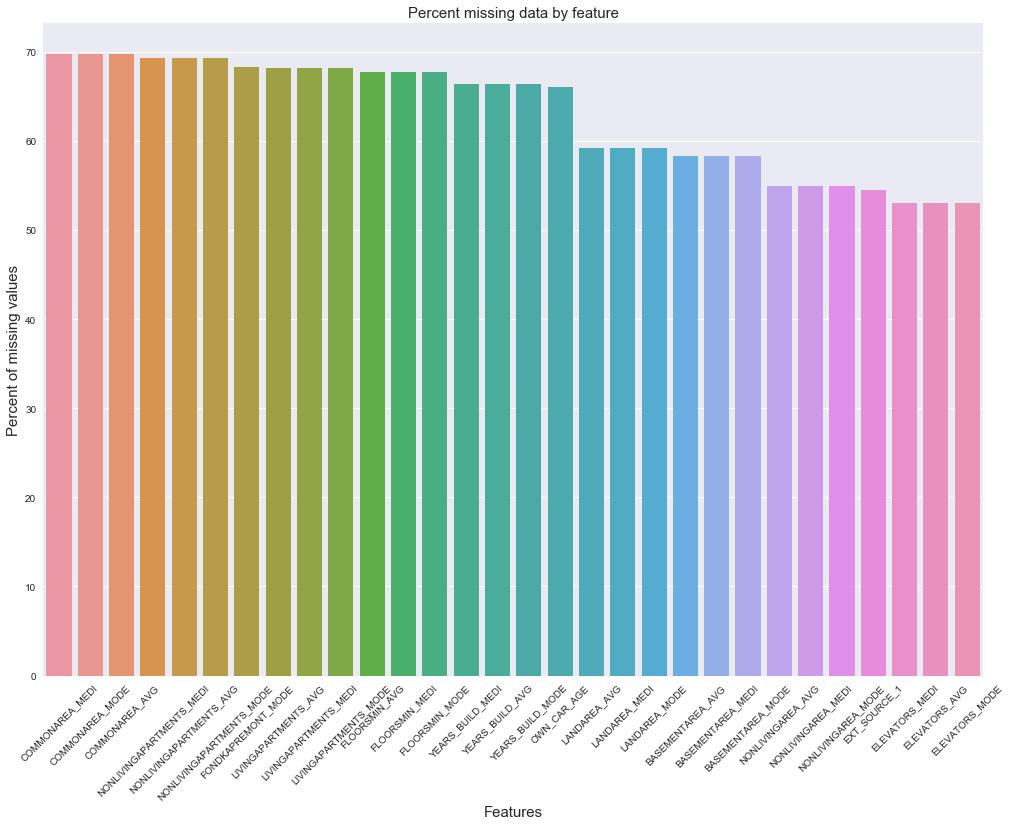

In [107]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Now let's look at the target value. Since this is a binary classification, the Target columns is 1 or 0.
Looking at the description file,
1: Clients with payment difficulties
0: All other cases

In [108]:
description[description['Row'] == 'TARGET']
description.loc[2,['ROW','Description']].values

,Table,Row,Description,Special
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN


array([nan,
       'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'],
      dtype=object)

In [109]:
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

We have far more 0s than 1s. This tells us that we are dealing with an inbalanced class problem.
- will need to tune parameters later accordingly
- will need to use stratified sampling

In [110]:
df.dtypes.value_counts()

float64    66
int64      39
object     16
dtype: int64

In [111]:
df.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Good news, most columns (string) do not have a lot of unique values.
First, will need to take care of string values.
Options
- Codify it (Male -> 0, Female -> 1) without creating new columns
- Create dummy variables (Similar to normalizing a SQL database) in new columns
- Drop the column (Last resort)

In [112]:
df.select_dtypes('object').nunique(dropna=False) <= 2

NAME_CONTRACT_TYPE             True
CODE_GENDER                   False
FLAG_OWN_CAR                   True
FLAG_OWN_REALTY                True
NAME_TYPE_SUITE               False
NAME_INCOME_TYPE              False
NAME_EDUCATION_TYPE           False
NAME_FAMILY_STATUS            False
NAME_HOUSING_TYPE             False
OCCUPATION_TYPE               False
WEEKDAY_APPR_PROCESS_START    False
ORGANIZATION_TYPE             False
FONDKAPREMONT_MODE            False
HOUSETYPE_MODE                False
WALLSMATERIAL_MODE            False
EMERGENCYSTATE_MODE           False
dtype: bool

In [114]:
encoder = LabelEncoder()

for col in df:
    if df[col].dtype == 'object':
        if int(df[col].nunique(dropna=False)) <= 2:
            df[col] = encoder.fit_transform(df[col])

df.head()
# Encoded: NAME_CONTRACT_TYPE, FLAG_OWN_CAR, FLAG_OWN_REALTY 

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,M,0,1,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0.0,0,F,0,0,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0.0,1,M,1,1,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [115]:
df.reset_index(inplace=True)
target = df['TARGET']
df.drop('TARGET', 1, inplace=True)

df.shape
df = pd.get_dummies(df)
df['TARGET'] = target
df.shape

(356255, 121)

(356255, 243)

## DAYS_EMPLOYED

In [117]:
(df['DAYS_BIRTH'] / -365).describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [118]:
# max value of 365243 seems worth looking into
df['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

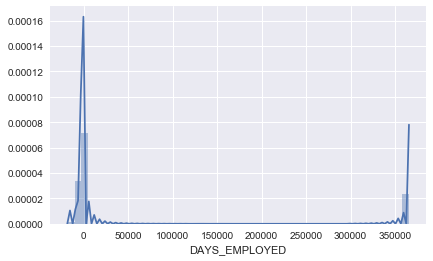

In [119]:
sns.distplot(df['DAYS_EMPLOYED'])

In [120]:
print('Number of samples in train + test set:', len(df))
print('Number of outliers in train + test set:', len(df[df['DAYS_EMPLOYED'] > 350000]))
print('% of outliers: {:.2f}'.format((len(df[df['DAYS_EMPLOYED'] > 350000]) / len(df)) * 100))

Number of samples in train + test set: 356255
Number of outliers in train + test set: 64648
% of outliers: 18.15


In [121]:
# Probability of default by outliers VS non-outliers in train set
print('Outliers & TARGET')
df[(df['DAYS_EMPLOYED'] > 350000) & df['TARGET'].notnull()]['TARGET'].describe()
print('Non-outliers & TARGET')
df[(df['DAYS_EMPLOYED'] <= 350000) & df['TARGET'].notnull()]['TARGET'].describe()

Outliers & TARGET


count    55374.000000
mean         0.053996
std          0.226013
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

Non-outliers & TARGET


count    252137.000000
mean          0.086600
std           0.281248
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64

In [122]:
# DAYS_EMPLOYED values of outliers
print('Value:', df[df['DAYS_EMPLOYED'] > 350000]['DAYS_EMPLOYED'].value_counts().index[0])
print('Count: ', df[df['DAYS_EMPLOYED'] > 350000]['DAYS_EMPLOYED'].value_counts().values[0])

Value: 365243
Count:  64648


## Recap
- Outliers = 'DAYS_EMPLOYED' > 350,000 days
- \# of samples in df (test + train dataset) = 356,255
- \# of outliers in df = 64,648
- % of outliers = 18.15
- \# 'DAYS_EMPLOYED' value of outliers = 365,243

Note
- The outliers on average have a probability of 5.4% of defaulting, while the rest have 8.66%.

Here I'll create a new column to indicate outliers that have the value 365243 for DAYS_EMPLOYED
Then, I'll replace those outlier values with NaN values in-place.

In [123]:
# create new column - True if outlier, else NaN
df['DAYS_EMPLOYED_OUTLIER'] = df['DAYS_EMPLOYED'] == 365243

# replace outliers value 365243 with NaN
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})

# check that it worked
print('DAYS_EMPLOYED_OUTLIER')
df['DAYS_EMPLOYED_OUTLIER'].value_counts(dropna=False)
print('DAYS_EMPLOYED')
df['DAYS_EMPLOYED'].value_counts(dropna=False)

DAYS_EMPLOYED_OUTLIER


False    291607
True      64648
Name: DAYS_EMPLOYED_OUTLIER, dtype: int64

DAYS_EMPLOYED


NaN         64648
-200.0        175
-199.0        171
-212.0        165
-224.0        163
-229.0        162
-230.0        161
-188.0        159
-384.0        158
-207.0        156
-216.0        156
-231.0        155
-233.0        152
-116.0        152
-196.0        151
-193.0        150
-215.0        149
-201.0        148
-254.0        148
-205.0        144
-222.0        142
-195.0        142
-240.0        142
-185.0        142
-234.0        142
-214.0        141
-237.0        141
-198.0        140
-192.0        140
-137.0        140
            ...  
-10241.0        1
-9294.0         1
-13354.0        1
-10289.0        1
-12994.0        1
-8384.0         1
-14786.0        1
-9816.0         1
-9310.0         1
-10337.0        1
-9282.0         1
-16226.0        1
-10333.0        1
-12470.0        1
-13898.0        1
-11100.0        1
-14057.0        1
-10323.0        1
-13902.0        1
-10321.0        1
-14067.0        1
-16554.0        1
-11630.0        1
-13006.0        1
-14079.0  

Now that the outliers were converted to NaN values, we can properly visualize DAYS_EMPLOYED on a histogram

Text(0.5,0,'Days Employed')

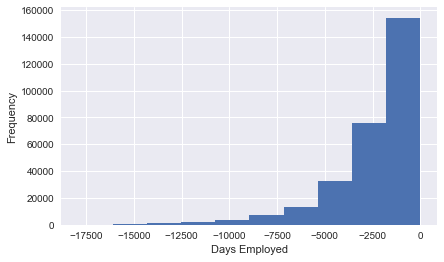

In [124]:
df['DAYS_EMPLOYED'].plot(kind='hist')
plt.xlabel('Days Employed')

## Target Correlation
What are the best indicators for an applicant's probability of having payment difficulties in the future?

In [125]:
target_correlation = df.corr()[['TARGET']]
target_correlation.columns = ['Target_Corr']

In [126]:
# show features with the strongest positive & negative correlation
target_correlation.sort_values('Target_Corr', ascending=False).head(10)
target_correlation.sort_values('Target_Corr').head(10)

,Target_Corr
TARGET,1.000000
DAYS_BIRTH,0.078239
DAYS_EMPLOYED,0.074958
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
NAME_INCOME_TYPE_Working,0.057481
DAYS_LAST_PHONE_CHANGE,0.055218
CODE_GENDER_M,0.054713
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994


,Target_Corr
EXT_SOURCE_3,-0.178919
EXT_SOURCE_2,-0.160472
EXT_SOURCE_1,-0.155317
NAME_EDUCATION_TYPE_Higher education,-0.056593
CODE_GENDER_F,-0.054704
NAME_INCOME_TYPE_Pensioner,-0.046209
ORGANIZATION_TYPE_XNA,-0.045987
DAYS_EMPLOYED_OUTLIER,-0.045987
FLOORSMAX_AVG,-0.044003
FLOORSMAX_MEDI,-0.043768


Strongest indicators
- DAYS_BIRTH: age of applicant expressed as number of days, in negative number
- DAYS_EMPLOYED: how long an applicant has been employed at the time of application
- EXT_SOURCE_1,2,3: ?

## DAYS_BIRTH

- Convert 'DAYS_BIRTH' to positive value
- Convert to age, create new 'Age' column
- Visualize the age distribution
- Identify any differences between those who default/did not default
- Assign age group, create 'Age group' column
- Look at mean probability of defaulting by age group

In [127]:
# Get absolute value
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])

# Convert to age
df['AGE'] = round(df['DAYS_BIRTH'] / 365, 2)

(array([  967.,  5670.,  7412.,  8022., 14280., 14573., 14986., 15411.,
        14494., 15086., 16622., 16824., 16328., 15724., 15405., 14095.,
        13540., 12991., 12402., 12800., 13904., 13128., 13067., 11934.,
        12124., 10399.,  9942.,  7778.,  4131.,  2216.]),
 array([20.1  , 21.734, 23.368, 25.002, 26.636, 28.27 , 29.904, 31.538,
        33.172, 34.806, 36.44 , 38.074, 39.708, 41.342, 42.976, 44.61 ,
        46.244, 47.878, 49.512, 51.146, 52.78 , 54.414, 56.048, 57.682,
        59.316, 60.95 , 62.584, 64.218, 65.852, 67.486, 69.12 ]),
 <a list of 30 Patch objects>)

Text(0.5,1,'Age Distribution - overall')

Text(0.5,0,'Age')

Text(0,0.5,'Count')

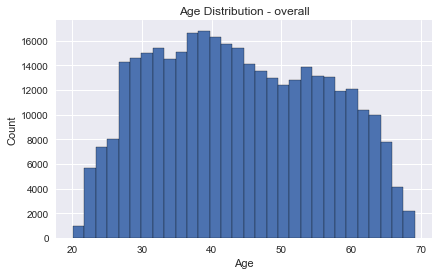

In [128]:
plt.hist(df['AGE'], bins=30, edgecolor='black')
plt.title('Age Distribution - overall')
plt.xlabel('Age')
plt.ylabel('Count')

<function matplotlib.pyplot.figure>

Text(0.5,0,'Age in Years')

Text(0,0.5,'Density')

Text(0.5,1,'Age Distribution by TARGET value')

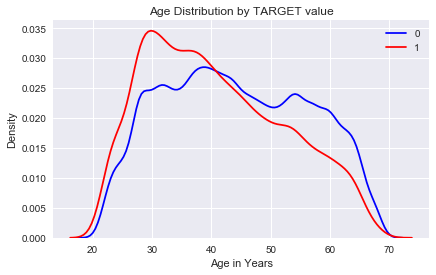

In [129]:
plt.figure
sns.kdeplot(df.loc[df['TARGET'] == 0, 'AGE'], label = '0', color ='blue')
sns.kdeplot(df.loc[df['TARGET'] == 1, 'AGE'], label = '1', color ='red')
plt.xlabel('Age in Years')
plt.ylabel('Density')
plt.title('Age Distribution by TARGET value')

In [130]:
# assign age groups
age_groups = df[['TARGET','AGE']].copy()
age_groups['AGE_GROUP'] = pd.cut(df['AGE'], bins = np.linspace(20, 70, num = 11))
age_groups.head(10)

,TARGET,AGE,AGE_GROUP
0,1.0,25.92,"(25.0, 30.0]"
1,0.0,45.93,"(45.0, 50.0]"
2,0.0,52.18,"(50.0, 55.0]"
3,0.0,52.07,"(50.0, 55.0]"
4,0.0,54.61,"(50.0, 55.0]"
5,0.0,46.41,"(45.0, 50.0]"
6,0.0,37.75,"(35.0, 40.0]"
7,0.0,51.64,"(50.0, 55.0]"
8,0.0,55.07,"(55.0, 60.0]"
9,0.0,39.64,"(35.0, 40.0]"


,TARGET,AGE
AGE_GROUP,,
"(20.0, 25.0]",0.122957,23.394903
"(25.0, 30.0]",0.111422,27.834420
"(30.0, 35.0]",0.102801,32.486738
"(35.0, 40.0]",0.089475,37.559993
"(40.0, 45.0]",0.078462,42.462027
"(45.0, 50.0]",0.074153,47.464228
"(50.0, 55.0]",0.066920,52.588660
"(55.0, 60.0]",0.055324,57.488286
"(60.0, 65.0]",0.052773,62.413321


<BarContainer object of 10 artists>

Text(0.5,1,'Probability of Default by Age Group')

Text(0.5,0,'Age Group')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

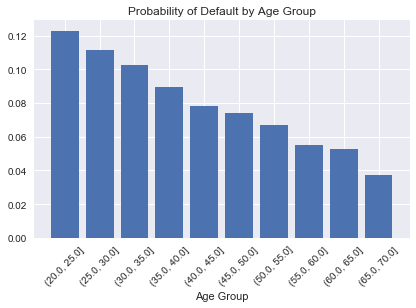

In [131]:
# default risk by age group
age_groups.groupby('AGE_GROUP').mean()
plt.bar(age_groups.groupby('AGE_GROUP').mean().index.astype('str'), age_groups.groupby('AGE_GROUP').mean()['TARGET'])
plt.title('Probability of Default by Age Group')
plt.xlabel('Age Group')
plt.xticks(rotation=45)

# EXT_SOURCE_1-3

First, will look at the description to understand what these 3 columns mean

In [132]:
cols = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','TARGET']

description[description['Row'].str.contains('EXT_SOURCE')]
df[cols].head()

,Table,Row,Description,Special
44,application_{train|test}.csv,EXT_SOURCE_1,Normalized score from external data source,normalized
45,application_{train|test}.csv,EXT_SOURCE_2,Normalized score from external data source,normalized
46,application_{train|test}.csv,EXT_SOURCE_3,Normalized score from external data source,normalized


,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,0.083037,0.262949,0.139376,1.0
1,0.311267,0.622246,NaN,0.0
2,NaN,0.555912,0.729567,0.0
3,NaN,0.650442,NaN,0.0
4,NaN,0.322738,NaN,0.0


In [133]:
print('% of missing values')
df.loc[:,df.columns.str.contains('EXT_SOURCE')].isnull().sum() / len(df)

% of missing values


EXT_SOURCE_1    0.544301
EXT_SOURCE_2    0.001875
EXT_SOURCE_3    0.195458
dtype: float64

In [134]:
df[cols].corr()[['TARGET']]

,TARGET
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919
TARGET,1.000000


These columns have inverse relations (negative correlations) with TARGET.
In other words: The higher the values for EXT_SOURCE, the less likey that the applicant will have payment difficulties

<Figure size 864x864 with 0 Axes>

Text(0.5,1,'Distribution of EXT_SOURCE_1 by "TARGET"')

Text(0.5,0,'EXT_SOURCE_1')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of EXT_SOURCE_2 by "TARGET"')

Text(0.5,0,'EXT_SOURCE_2')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of EXT_SOURCE_3 by "TARGET"')

Text(0.5,0,'EXT_SOURCE_3')

Text(0,0.5,'Density')

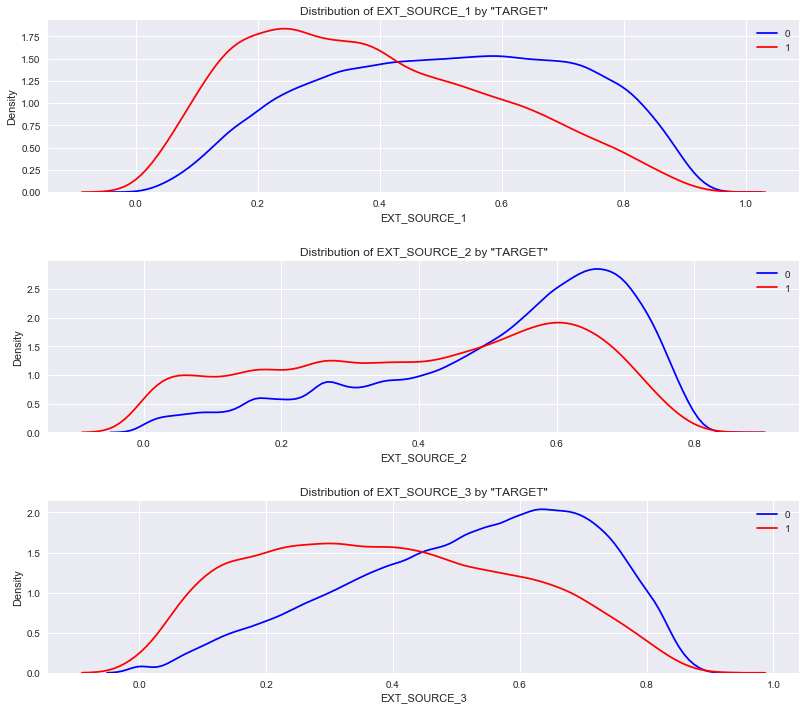

In [135]:
cols = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.4)
for i, col in enumerate(cols):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(df.loc[df['TARGET'] == 0, col], label='0', color='blue')
    sns.kdeplot(df.loc[df['TARGET'] == 1, col], label='1', color='red')
    plt.title(f'Distribution of {col} by "TARGET"')
    plt.xlabel(col)
    plt.ylabel('Density')

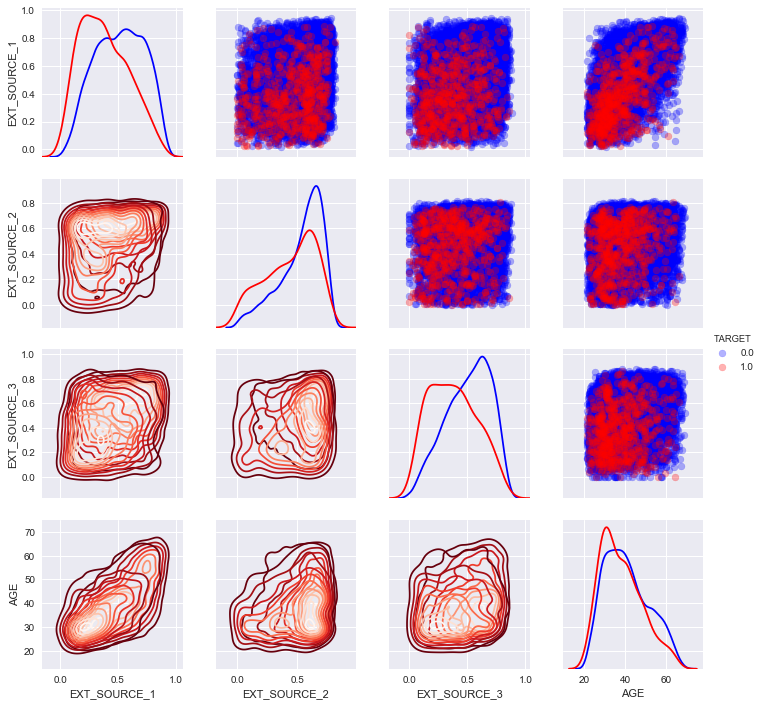

In [136]:
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE', 'TARGET']

pg = df[cols].dropna().sample(10000)
g = sns.PairGrid(data=pg, hue='TARGET', vars=cols[:-1], diag_sharey=False, palette={0:'Blue', 1:'Red'})
g.map_upper(plt.scatter, alpha = 0.3)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, cmap='Reds_r')
g.add_legend()

## Missing values

Analyze columns that have NA values.
Drop some columns, if they do not have strong/moderate correlation with TARGET
Fill in NA values with median, if they have a higher correlation with TARGET

In [137]:
na_rows = df[df.drop('TARGET', 1).isnull().any(axis=1)]
na_rows.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity 

In [138]:
na_cols_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False) / len(df), columns=['pct'])
na_cols_df = na_cols_df[na_cols_df['pct'] > 0]
na_cols = na_cols_df.index.values

unique_vals = df.loc[:,na_cols].nunique()
unique_vals = pd.DataFrame(unique_vals, columns=['nunique'])
na_cols_df = na_cols_df.join(unique_vals)

target_correlation = df.corr()[['TARGET']]
target_correlation.columns = ['Target_Corr']
na_cols_df = na_cols_df.join(target_correlation)
na_cols_df.drop('TARGET',0,inplace=True)
na_cols_df.head()

,pct,nunique,Target_Corr
COMMONAREA_MEDI,0.697141,3289,-0.018573
COMMONAREA_AVG,0.697141,3271,-0.018550
COMMONAREA_MODE,0.697141,3215,-0.016340
NONLIVINGAPARTMENTS_MODE,0.692933,178,-0.001557
NONLIVINGAPARTMENTS_MEDI,0.692933,231,-0.002757


In [139]:
(abs(na_cols_df['Target_Corr'])).describe()
(abs(na_cols_df['Target_Corr'])).sort_values()

count    62.000000
mean      0.029230
std       0.033971
min       0.000788
25%       0.011557
50%       0.022115
75%       0.032729
max       0.178919
Name: Target_Corr, dtype: float64

AMT_REQ_CREDIT_BUREAU_WEEK      0.000788
AMT_REQ_CREDIT_BUREAU_HOUR      0.000930
NONLIVINGAPARTMENTS_MODE        0.001557
AMT_REQ_CREDIT_BUREAU_QRT       0.002022
AMT_REQ_CREDIT_BUREAU_DAY       0.002704
NONLIVINGAPARTMENTS_MEDI        0.002757
NONLIVINGAPARTMENTS_AVG         0.003176
OBS_60_CNT_SOCIAL_CIRCLE        0.009022
YEARS_BEGINEXPLUATATION_MODE    0.009036
OBS_30_CNT_SOCIAL_CIRCLE        0.009131
CNT_FAM_MEMBERS                 0.009308
YEARS_BEGINEXPLUATATION_AVG     0.009728
YEARS_BEGINEXPLUATATION_MEDI    0.009993
LANDAREA_MODE                   0.010174
LANDAREA_AVG                    0.010885
LANDAREA_MEDI                   0.011256
AMT_REQ_CREDIT_BUREAU_MON       0.012462
NONLIVINGAREA_MODE              0.012711
AMT_ANNUITY                     0.012817
NONLIVINGAREA_MEDI              0.013337
NONLIVINGAREA_AVG               0.013578
COMMONAREA_MODE                 0.016340
ENTRANCES_MODE                  0.017387
COMMONAREA_AVG                  0.018550
COMMONAREA_MEDI 

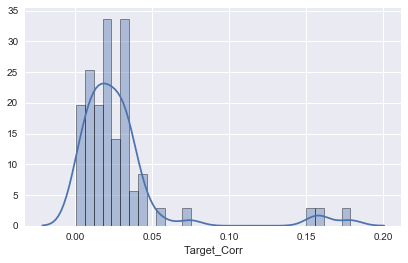

In [140]:
sns.distplot(abs(na_cols_df['Target_Corr']), bins=31, hist_kws=dict(edgecolor="k", linewidth=1))

In [141]:
na_cols_df['Abs_Target_Corr'] = abs(na_cols_df['Target_Corr'])
drop_index = len(na_cols_df[(na_cols_df['Abs_Target_Corr'] < 0.01)])
drop_index

13

In [142]:
print('Features to drop')
na_cols_df.sort_values('Abs_Target_Corr')[:drop_index]
print('Features left')
na_cols_df.sort_values('Abs_Target_Corr')[drop_index:]

Features to drop


,pct,nunique,Target_Corr,Abs_Target_Corr
AMT_REQ_CREDIT_BUREAU_WEEK,0.133522,9,0.000788,0.000788
AMT_REQ_CREDIT_BUREAU_HOUR,0.133522,5,0.000930,0.000930
NONLIVINGAPARTMENTS_MODE,0.692933,178,-0.001557,0.001557
AMT_REQ_CREDIT_BUREAU_QRT,0.133522,11,-0.002022,0.002022
AMT_REQ_CREDIT_BUREAU_DAY,0.133522,9,0.002704,0.002704
NONLIVINGAPARTMENTS_MEDI,0.692933,231,-0.002757,0.002757
NONLIVINGAPARTMENTS_AVG,0.692933,410,-0.003176,0.003176
OBS_60_CNT_SOCIAL_CIRCLE,0.002947,35,0.009022,0.009022
YEARS_BEGINEXPLUATATION_MODE,0.485223,224,-0.009036,0.009036
OBS_30_CNT_SOCIAL_CIRCLE,0.002947,36,0.009131,0.009131


Features left


,pct,nunique,Target_Corr,Abs_Target_Corr
LANDAREA_MODE,0.591835,3621,-0.010174,0.010174
LANDAREA_AVG,0.591835,3580,-0.010885,0.010885
LANDAREA_MEDI,0.591835,3618,-0.011256,0.011256
AMT_REQ_CREDIT_BUREAU_MON,0.133522,24,-0.012462,0.012462
NONLIVINGAREA_MODE,0.549511,3432,-0.012711,0.012711
AMT_ANNUITY,0.000101,14166,-0.012817,0.012817
NONLIVINGAREA_MEDI,0.549511,3419,-0.013337,0.013337
NONLIVINGAREA_AVG,0.549511,3397,-0.013578,0.013578
COMMONAREA_MODE,0.697141,3215,-0.016340,0.016340
ENTRANCES_MODE,0.500785,30,-0.017387,0.017387


In [143]:
drop_features = na_cols_df.sort_values('Abs_Target_Corr')[:drop_index].index.values
drop_features

array(['AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'NONLIVINGAPARTMENTS_MODE', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'NONLIVINGAPARTMENTS_MEDI',
       'NONLIVINGAPARTMENTS_AVG', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'YEARS_BEGINEXPLUATATION_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'CNT_FAM_MEMBERS', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI'], dtype=object)

In [144]:
print(f'Before: {len(df.columns)} features')
na_cols_df.drop(drop_features,0,inplace=True)
df.drop(drop_features,1,inplace=True)
print(f'After: {len(df.columns)} features')

Before: 245 features
After: 232 features


## Filling in NA values

In [145]:
na_cols_df.describe()

,pct,nunique,Target_Corr,Abs_Target_Corr
count,49.000000,49.000000,49.000000,49.000000
mean,0.474699,7517.428571,-0.025298,0.035553
std,0.223458,25860.532119,0.043648,0.035611
min,0.000003,9.000000,-0.178919,0.010174
25%,0.494985,63.000000,-0.032739,0.019025
50%,0.530743,1163.000000,-0.022326,0.027284
75%,0.660316,3621.000000,-0.013337,0.033614
max,0.697141,134315.000000,0.074958,0.178919


In [146]:
na_cols = na_cols_df.index.values
na_cols

array(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MODE',
       'LANDAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI',
       'BASEMENTAREA_MODE', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_AVG', 'EXT_SOURCE_1', 'ELEVATORS_AVG',
       'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'APARTMENTS_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'ENTRANCES_MEDI',
       'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'TOTALAREA_MODE',
       'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', '

In [147]:
na_cols_df.transpose()
df[na_cols].describe()
df.loc[df.drop('TARGET', 1).isnull().any(axis=1),na_cols]

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,FLOORSMIN_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,YEARS_BUILD_AVG,OWN_CAR_AGE,LANDAREA_AVG,LANDAREA_MODE,LANDAREA_MEDI,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,NONLIVINGAREA_MODE,NONLIVINGAREA_MEDI,NONLIVINGAREA_AVG,EXT_SOURCE_1,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,ENTRANCES_MEDI,ENTRANCES_AVG,ENTRANCES_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,FLOORSMAX_MODE,TOTALAREA_MODE,EXT_SOURCE_3,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_MON,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE
pct,0.697141,0.697141,0.697141,0.682037,0.682037,0.682037,0.676785,0.676785,0.676785,0.663306,0.663306,0.663306,0.660316,0.591835,0.591835,0.591835,0.582684,0.582684,0.582684,0.549511,0.549511,0.549511,0.544301,0.530743,0.530743,0.530743,0.505110,0.505110,0.505110,0.500785,0.500785,0.500785,0.499367,0.499367,0.499367,0.494985,0.494985,0.494985,0.480148,0.195458,0.181466,0.133522,0.133522,0.002947,0.002947,0.001875,0.000780,0.000101,0.000003
nunique,3289.000000,3271.000000,3215.000000,1917.000000,1119.000000,749.000000,25.000000,318.000000,47.000000,151.000000,154.000000,149.000000,63.000000,3580.000000,3621.000000,3618.000000,3831.000000,3821.000000,3891.000000,3432.000000,3419.000000,3397.000000,134315.000000,266.000000,46.000000,26.000000,770.000000,1163.000000,2391.000000,46.000000,294.000000,30.000000,5272.000000,5360.000000,5382.000000,49.000000,414.000000,25.000000,5191.000000,814.000000,12895.000000,25.000000,24.000000,10.000000,9.000000,127157.000000,1291.000000,14166.000000,3846.000000
Target_Corr,-0.018573,-0.018550,-0.016340,-0.025031,-0.024621,-0.023393,-0.032698,-0.033614,-0.033394,-0.022326,-0.022068,-0.022149,0.037612,-0.010885,-0.010174,-0.011256,-0.022746,-0.022081,-0.019952,-0.012711,-0.013337,-0.013578,-0.155317,-0.034199,-0.033863,-0.032131,-0.027284,-0.029184,-0.029498,-0.019025,-0.019172,-0.017387,-0.032997,-0.032739,-0.030685,-0.043768,-0.044003,-0.043226,-0.032596,-0.178919,0.074958,0.019930,-0.012462,0.032248,0.031276,-0.160472,-0.039645,-0.012817,0.055218
Abs_Target_Corr,0.018573,0.018550,0.016340,0.025031,0.024621,0.023393,0.032698,0.033614,0.033394,0.022326,0.022068,0.022149,0.037612,0.010885,0.010174,0.011256,0.022746,0.022081,0.019952,0.012711,0.013337,0.013578,0.155317,0.034199,0.033863,0.032131,0.027284,0.029184,0.029498,0.019025,0.019172,0.017387,0.032997,0.032739,0.030685,0.043768,0.044003,0.043226,0.032596,0.178919,0.074958,0.019930,0.012462,0.032248,0.031276,0.160472,0.039645,0.012817,0.055218


,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,FLOORSMIN_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,YEARS_BUILD_AVG,OWN_CAR_AGE,LANDAREA_AVG,LANDAREA_MODE,LANDAREA_MEDI,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,NONLIVINGAREA_MODE,NONLIVINGAREA_MEDI,NONLIVINGAREA_AVG,EXT_SOURCE_1,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,ENTRANCES_MEDI,ENTRANCES_AVG,ENTRANCES_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,FLOORSMAX_MODE,TOTALAREA_MODE,EXT_SOURCE_3,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_MON,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE
count,107895.000000,107895.000000,107895.000000,113276.000000,113276.000000,113276.000000,115147.000000,115147.000000,115147.000000,119949.000000,119949.000000,119949.000000,121014.000000,145411.000000,145411.000000,145411.000000,148671.000000,148671.000000,148671.000000,160489.000000,160489.000000,160489.000000,162345.000000,167175.000000,167175.000000,167175.000000,176307.000000,176307.000000,176307.000000,177848.000000,177848.000000,177848.000000,178353.000000,178353.000000,178353.000000,179914.000000,179914.000000,179914.000000,185200.000000,286622.000000,291607.000000,308687.000000,308687.000000,355205.000000,355205.000000,3.555870e+05,3.559770e+05,356219.000000,356254.000000
mean,0.044994,0.045045,0.042930,0.101495,0.102674,0.106382,0.228878,0.232817,0.232504,0.755548,0.759452,0.752283,12.023741,0.066454,0.065092,0.067296,0.088673,0.088178,0.087750,0.027183,0.028386,0.028503,0.501965,0.079819,0.078930,0.075346,0.114914,0.118549,0.118138,0.149494,0.150015,0.145471,0.108089,0.109279,0.106641,0.226922,0.227331,0.223315,0.103193,0.509350,-2396.698937,1.911564,0.231697,0.143452,0.100198,5.148900e-01,5.280200e+05,27425.560657,-978.580852
std,0.077140,0.077045,0.075437,0.093418,0.094541,0.098779,0.161725,0.161909,0.162419,0.112057,0.110112,0.113267,11.880848,0.081287,0.081911,0.082267,0.082312,0.082017,0.084076,0.070723,0.070574,0.069880,0.210045,0.135249,0.135133,0.133025,0.108745,0.109824,0.108954,0.100450,0.100139,0.101088,0.111194,0.112881,0.112555,0.145453,0.145051,0.144126,0.108041,0.194141,2334.479967,1.865338,0.855949,0.456579,0.368259,1.897531e-01,3.660650e+05,14732.808190,835.063902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000527,-17912.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,4.050000e+04,1615.500000,-4361.000000
25%,0.007900,0.007900,0.007300,0.050400,0.051300,0.054200,0.083300,0.083300,0.083300,0.691400,0.699400,0.687200,5.000000,0.018700,0.016600,0.018800,0.044500,0.044100,0.041000,0.000000,0.000000,0.000000,0.335503,0.000000,0.000000,0.000000,0.052500,0.058300,0.057700,0.069000,0.069000,0.069000,0.045800,0.046200,0.043100,0.166700,0.166700,0.166700,0.041500,0.368969,-3200.000000,0.000000,0.000000,0.000000,0.000000,3.949551e-01,2.340000e+05,16731.000000,-1592.000000
50%,0.021000,0.021300,0.019200,0.075600,0.077000,0.077100,0.208300,0.208300,0.208300,0.758500,0.764800,0.755200,9.000000,0.048200,0.045900,0.048700,0.076500,0.076100,0.074900,0.001100,0.003100,0.003600,0.506155,0.000000,0.000000,0.000000,0.084000,0.087400,0.088000,0.137900,0.137900,0.137900,0.074900,0.075400,0.073300,0.166700,0.166700,0.166700,0.069000,0.533482,-1663.000000,1.000000,0.000000,0.000000,0.000000,5.648491e-01,4.500000e+05,25078.500000,-771.000000
75%,0.051800,0.051900,0.049300,0.121000,0.123100,0.131300,0.375000,0.375000,0.375000,0.825600,0.823600,0.823200,15.000000,0.085800,0.084300,0.087000,0.112300,0.111800,0.1

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,FLOORSMIN_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,YEARS_BUILD_AVG,OWN_CAR_AGE,LANDAREA_AVG,LANDAREA_MODE,LANDAREA_MEDI,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,NONLIVINGAREA_MODE,NONLIVINGAREA_MEDI,NONLIVINGAREA_AVG,EXT_SOURCE_1,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,ENTRANCES_MEDI,ENTRANCES_AVG,ENTRANCES_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,FLOORSMAX_MODE,TOTALAREA_MODE,EXT_SOURCE_3,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_MON,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE
0,0.0144,0.0143,0.0144,0.0202,0.0205,0.0220,0.1250,0.1250,0.1250,0.6243,0.6341,0.6192,NaN,0.0369,0.0377,0.0375,0.0369,0.0369,0.0383,0.0000,0.0000,0.0000,0.083037,0.0000,0.00,0.0000,0.0252,0.0250,0.0247,0.0690,0.0690,0.0690,0.0190,0.0193,0.0198,0.0833,0.0833,0.0833,0.0149,0.139376,-637.0,1.0,0.0,2.0,2.0,0.262949,351000.0,24700.5,-1134.0
1,0.0608,0.0605,0.0497,0.0773,0.0787,0.0790,0.3333,0.3333,0.3333,0.7987,0.8040,0.7960,NaN,0.0130,0.0128,0.0132,0.0529,0.0529,0.0538,0.0000,0.0100,0.0098,0.311267,0.0800,0.08,0.0806,0.0924,0.0968,0.0959,0.0345,0.0345,0.0345,0.0549,0.0558,0.0554,0.2917,0.2917,0.2917,0.0714,NaN,-1188.0,0.0,0.0,0.0,0.0,0.622246,1129500.0,35698.5,-828.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.729567,-225.0,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,-815.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3039.0,NaN,NaN,0.0,0.0,0.650442,297000.0,29686.5,-617.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3038.0,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,-1106.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621226,-1588.0,1.0,0.0,0.0,0.0,0.354225,454500.0,27517.5,-2536.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.774761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.492060,-3130.0,2.0,1.0,0.0,0.0,0.724000,1395000.0,41301.0,-1562.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540654,-449.0,0.0,0.0,0.0,0.0,0.714279,1530000.0,42075.0,-1070.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.751724,NaN,1.0,0.0,0.0,0.0,0.205747,913500.0,33826.5,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2019.0,NaN,NaN,0.0,0.0,0.746644,405000.0,20250.0,-1673.0


<Figure size 1152x1440 with 0 Axes>

Text(0.5,1,'Distribution of COMMONAREA_MEDI by "TARGET"')

Text(0.5,0,'COMMONAREA_MEDI')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of COMMONAREA_AVG by "TARGET"')

Text(0.5,0,'COMMONAREA_AVG')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of COMMONAREA_MODE by "TARGET"')

Text(0.5,0,'COMMONAREA_MODE')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of LIVINGAPARTMENTS_AVG by "TARGET"')

Text(0.5,0,'LIVINGAPARTMENTS_AVG')

Text(0,0.5,'Density')

Text(0.5,1,'Distribution of LIVINGAPARTMENTS_MEDI by "TARGET"')

Text(0.5,0,'LIVINGAPARTMENTS_MEDI')

Text(0,0.5,'Density')

ValueError: num must be 1 <= num <= 5, not 6

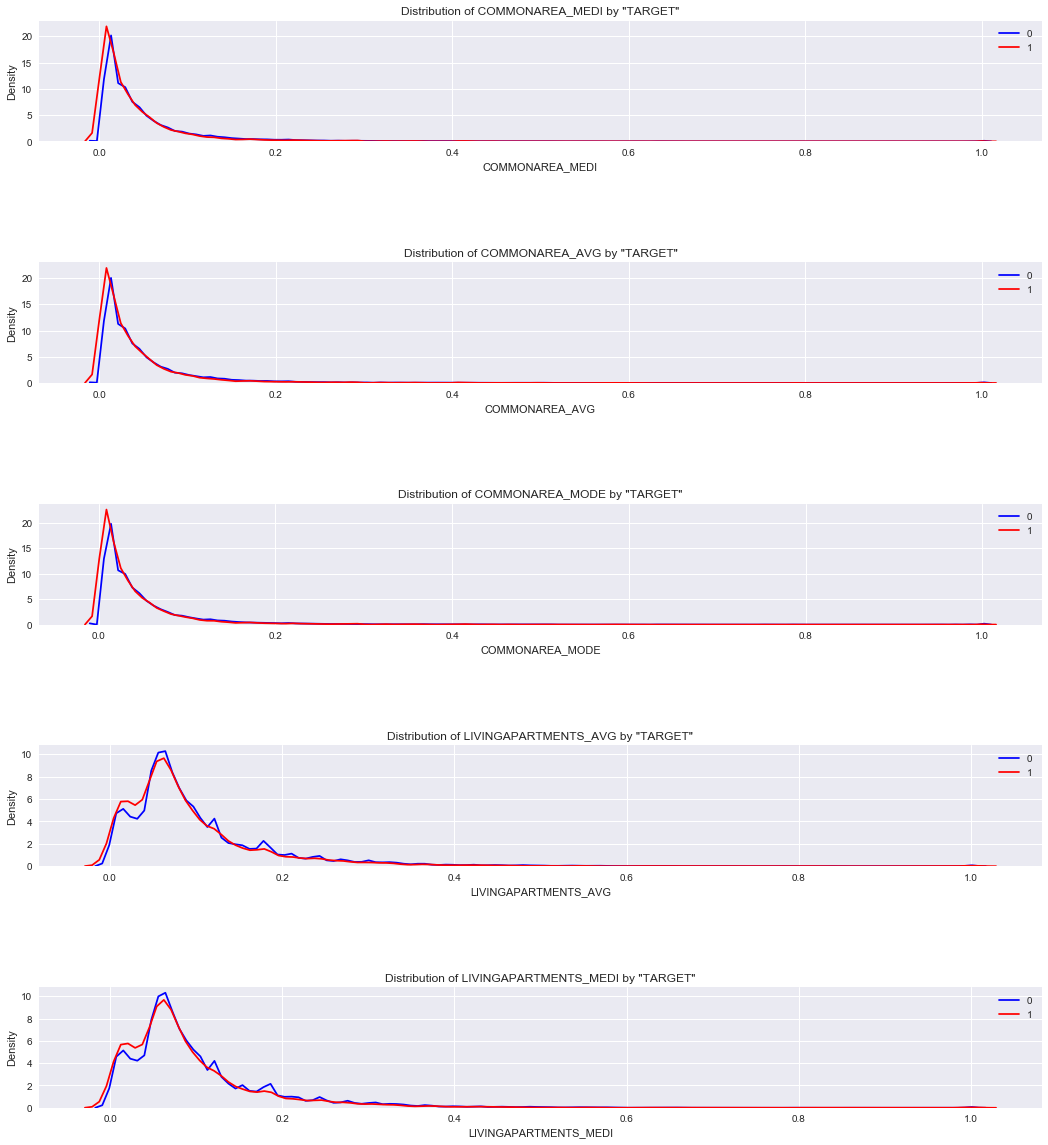

In [148]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(hspace=1)
for i, col in enumerate(na_cols_df.index.values):
    plt.subplot(5, 1, i + 1)
    sns.kdeplot(df.loc[df['TARGET'] == 0, col], label='0', color='blue')
    sns.kdeplot(df.loc[df['TARGET'] == 1, col], label='1', color='red')
    plt.title(f'Distribution of {col} by "TARGET"')
    plt.xlabel(col)
    plt.ylabel('Density')

# Checkpoint1

In [ ]:
df['TARGET'] = df[:split]['TARGET'].apply(lambda x: int(x))
df.to_feather('input/checkpoint1.feather')